In [17]:
# Import the modüles
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Model
from keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave

import numpy as np
import tensorflow as tf

path = "./colorization"

In [18]:
# Normalize images
train_datagen = ImageDataGenerator(rescale=1/255)

# Resize images
train = train_datagen.flow_from_directory(path, target_size=(256, 256), batch_size=340, class_mode=None)

Found 7129 images belonging to 1 classes.


## RGB TO LAB
* Think of LAB image as a grey image in L channel and all color info stored in A and B channels. The input to the network will be the L channel, so we assign L channel to X vector. And assign A and B to Y.

model.fit(x, y, epochs=5, shuffle=True)
Y= COLOR
X = LIGHTNESS

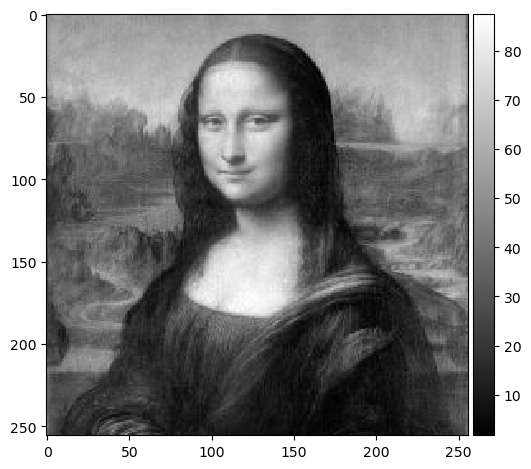

In [19]:
# Let's convert monalisa rgb picture to lab to understand
from skimage.io import imshow

img = load_img("./img/autoencoders/monalisa.jpeg")
lab = rgb2lab(img)
L = lab[:, :, 0]
A = lab[:, : ,1]
B = lab[:, :, 2]

imshow(L, cmap='gray')

In [20]:
X = []
Y= []
for img in train[0]:
    try:
        lab = rgb2lab(img)
        X.append(lab[:, :, 0])
        Y.append(lab[: ,:, 1:] / 128) # A and B values range from -127 to 128 (normalize it) tanh(-1 to 1) NOT RELU FOR PRED!
    except:
        print("Cant convert to rgb to lab and didnt map to X and Y array!")

In [21]:
X = np.array(X)
Y = np.array(Y)

X = X.reshape(X.shape+ (1,)) # dimensions to be the same for X and Y

X.shape, Y.shape

((340, 256, 256, 1), (340, 256, 256, 2))

In [22]:
from tensorflow.keras.models import Sequential

# Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))


#Decoder
#Decoder
#Note: For the last layer we use tanh instead of Relu. 
#This is because we are colorizing the image in this layer using 2 filters, A and B.
#A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used
#as it also has the range between -1 and 1. 
#Other functions go from 0 to 1.
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 512)      

In [ ]:
model.fit(X,Y,validation_split=0.1, epochs=300, batch_size=16)

model.save('colorize_autoencoderv2.model')

1/1 [==============================] - 0s 109ms/step


2022-11-20 01:46:28.754701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


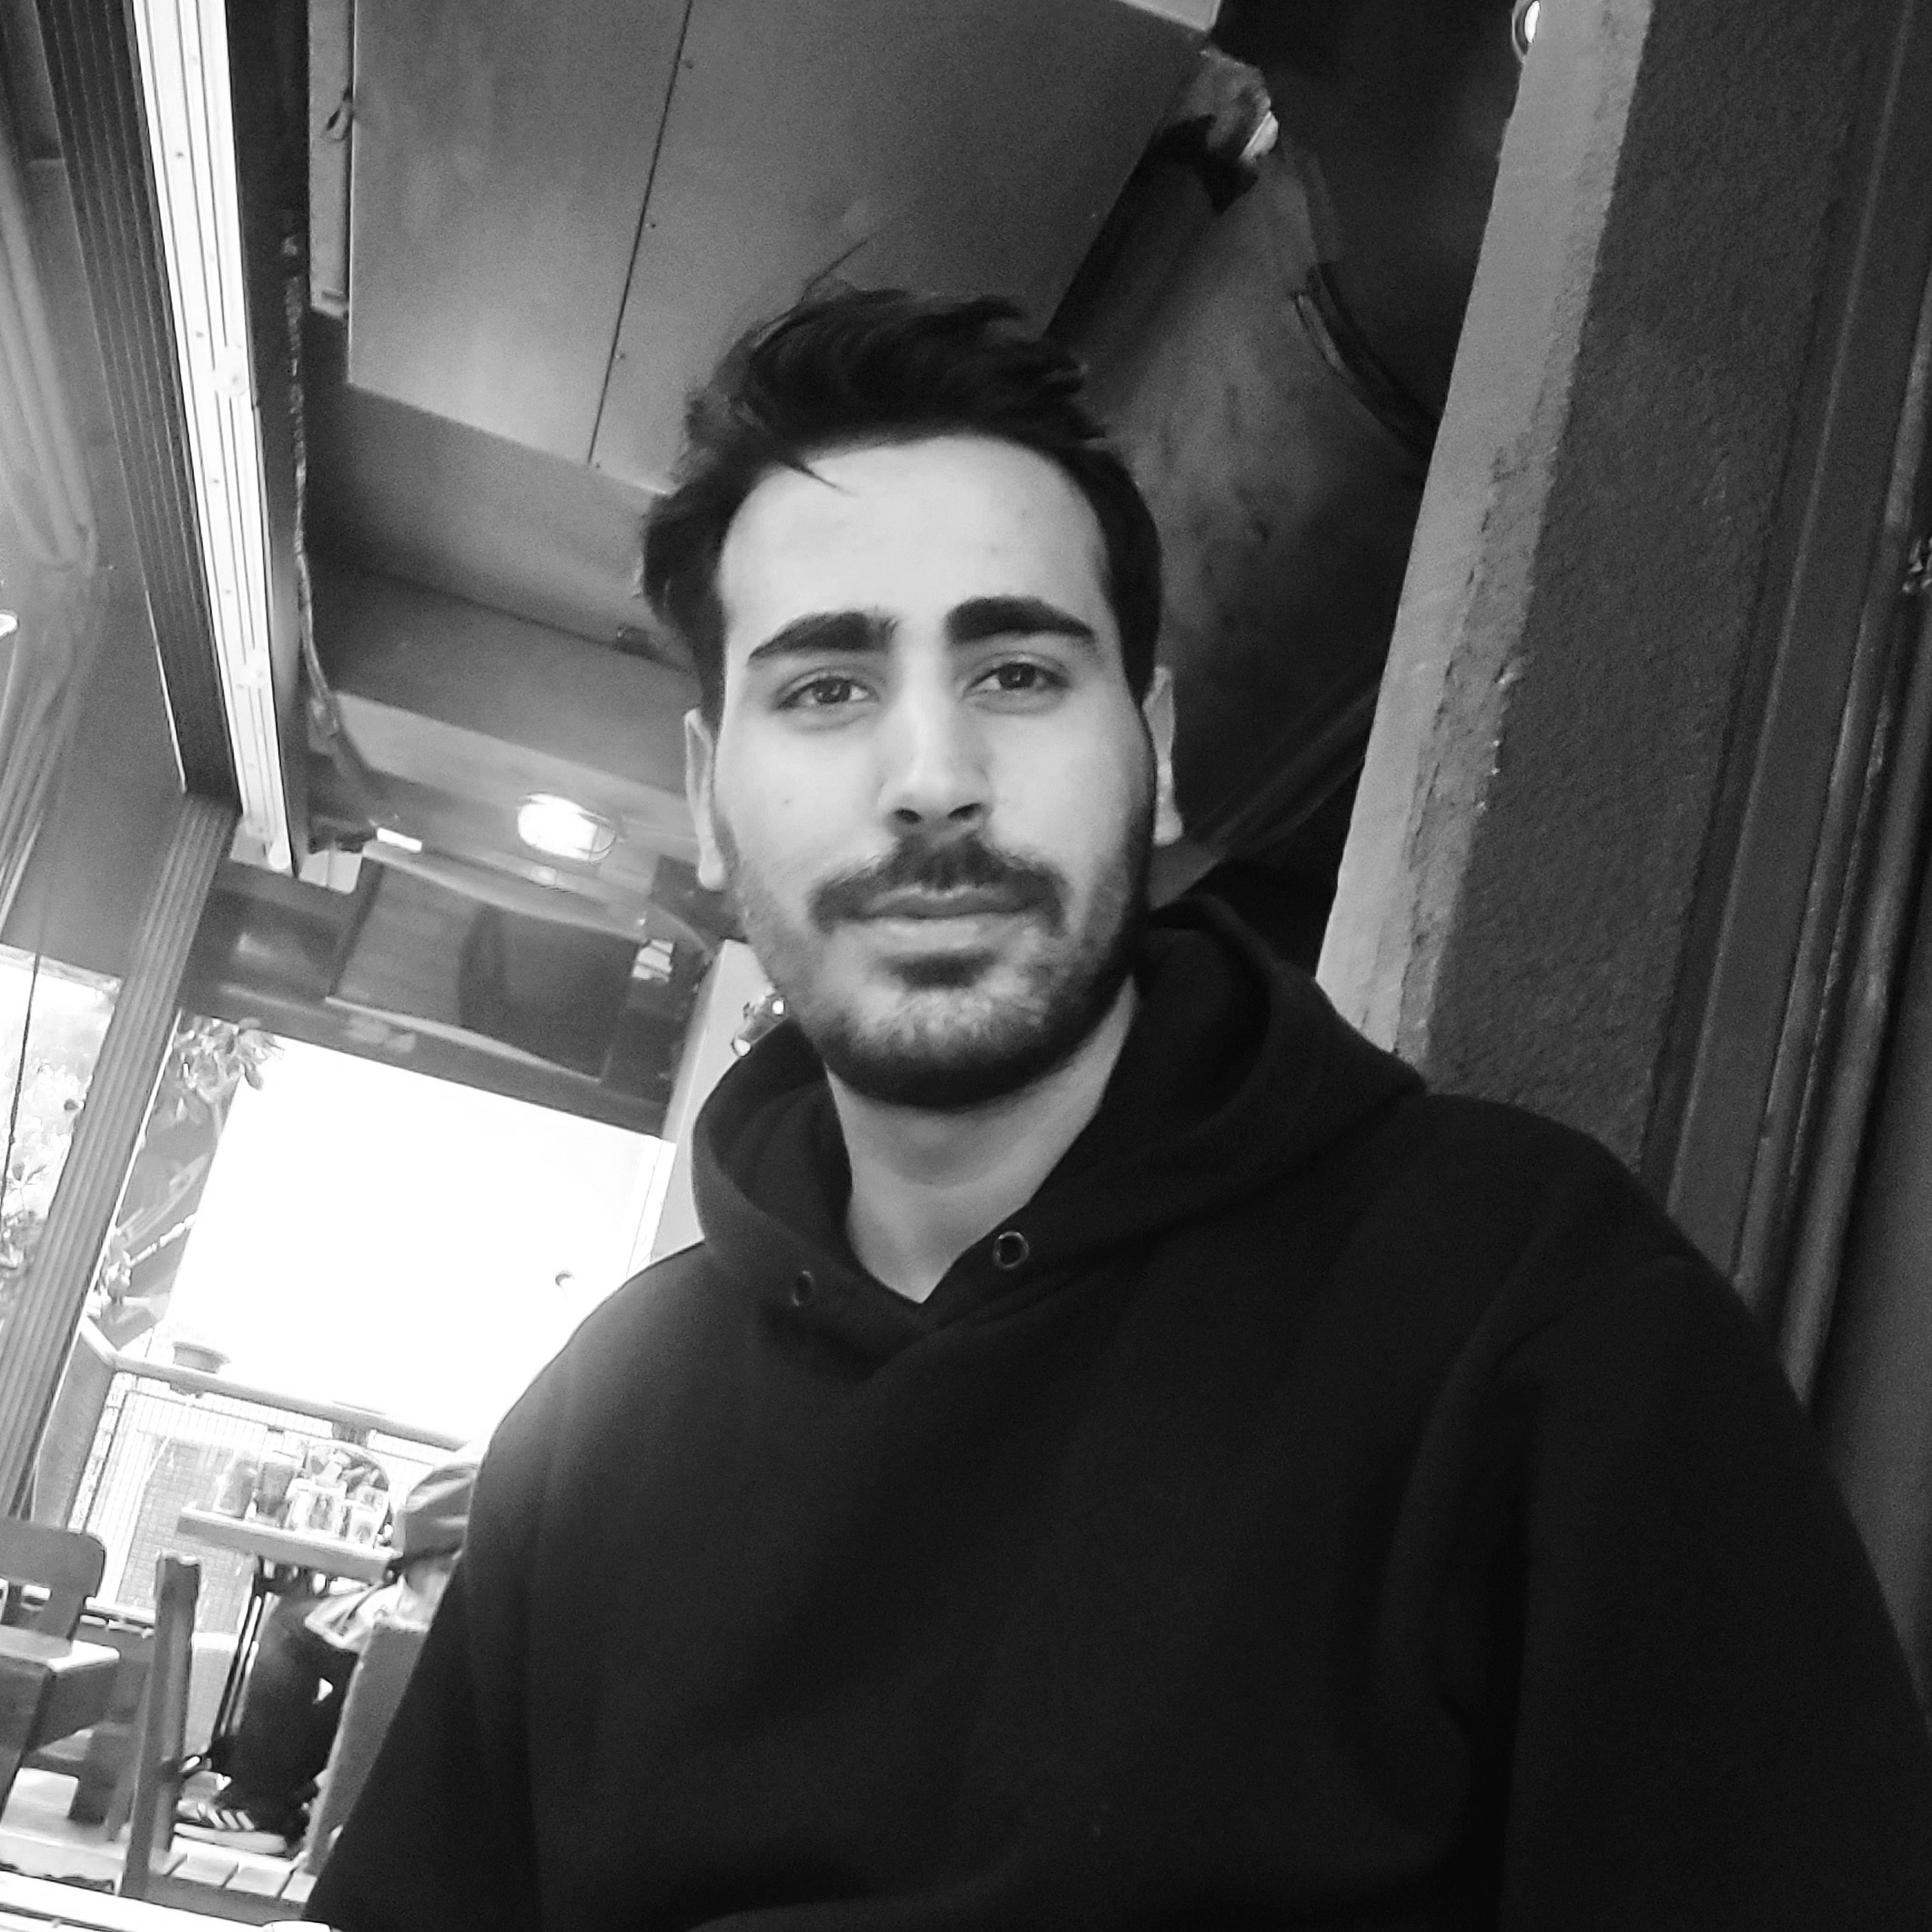

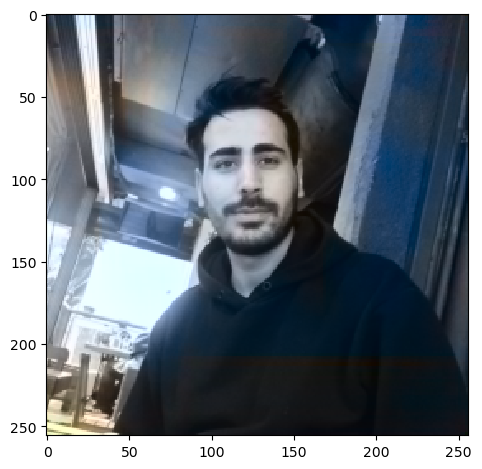

In [39]:
model = tf.keras.models.load_model('colorize_autoencoderv2.model', custom_objects=None, compile=True)

img_color = []

img = img_to_array(load_img('./grayimg/gray.png'))
img = resize(img, (256, 256))
img_color.append(img)

img_color = np.array(img_color, dtype=float)
img_color = rgb2lab(1/255*img_color)[:,:,:,0]
img_color = img_color.reshape(img_color.shape+(1,))

output = model.predict(img_color)
output = output*128

result = np.zeros((256, 256, 3))
result[:, :, 0] = img_color[0][:,:,0]
result[:, :, 1:] = output[0]
imshow(lab2rgb(result))

from IPython.display import Image
Image(filename='./grayimg/gray.png', width=260, height=260) 

1/1 [==============================] - 0s 112ms/step


2022-11-20 01:46:49.244760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


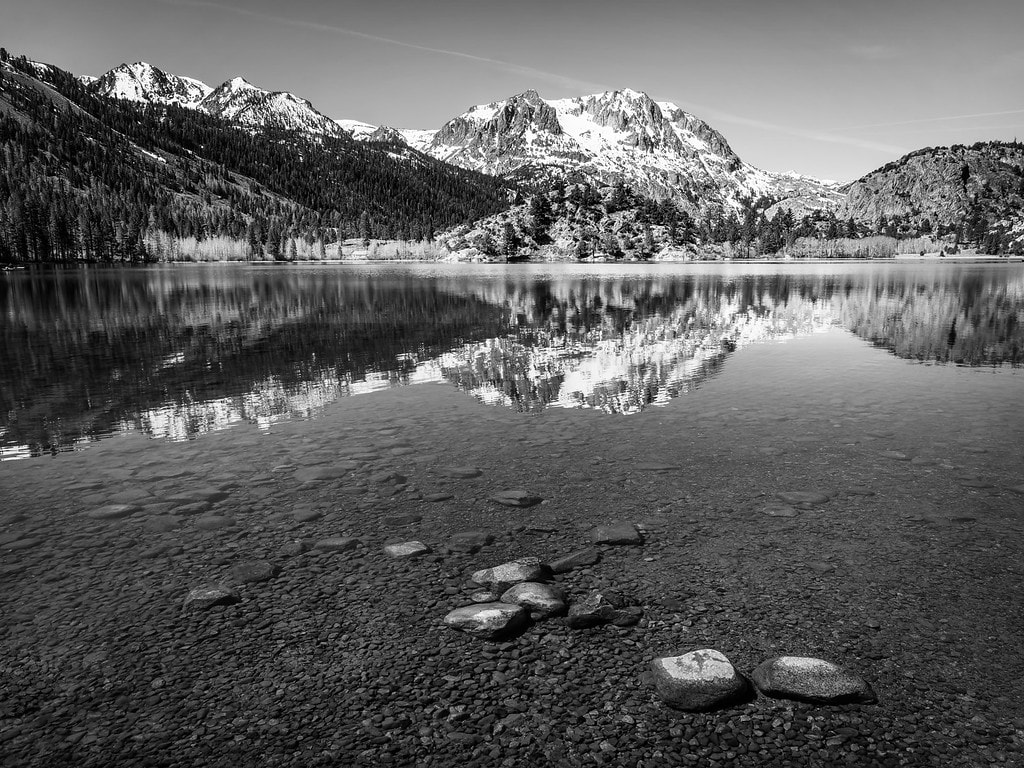

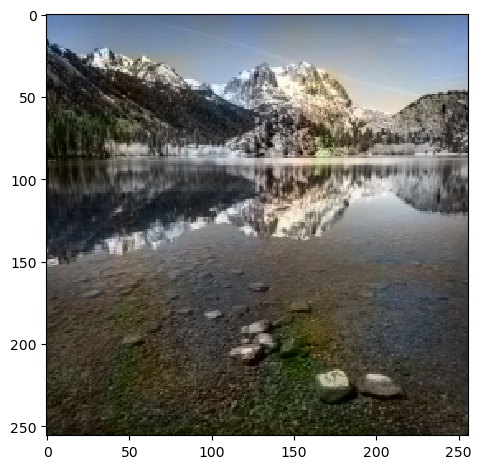

In [40]:
model = tf.keras.models.load_model('colorize_autoencoderv2.model', custom_objects=None, compile=True)

img_color = []

img = img_to_array(load_img('./grayimg/gray3.jpg'))
img = resize(img, (256, 256))
img_color.append(img)

img_color = np.array(img_color, dtype=float)
img_color = rgb2lab(1/255*img_color)[:,:,:,0]
img_color = img_color.reshape(img_color.shape+(1,))

output = model.predict(img_color)
output = output*128

result = np.zeros((256, 256, 3))
result[:, :, 0] = img_color[0][:,:,0]
result[:, :, 1:] = output[0]
imshow(lab2rgb(result))

Image(filename='./grayimg/gray3.jpg', width=260, height=260) 

1/1 [==============================] - 0s 121ms/step


2022-11-20 01:51:53.316214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


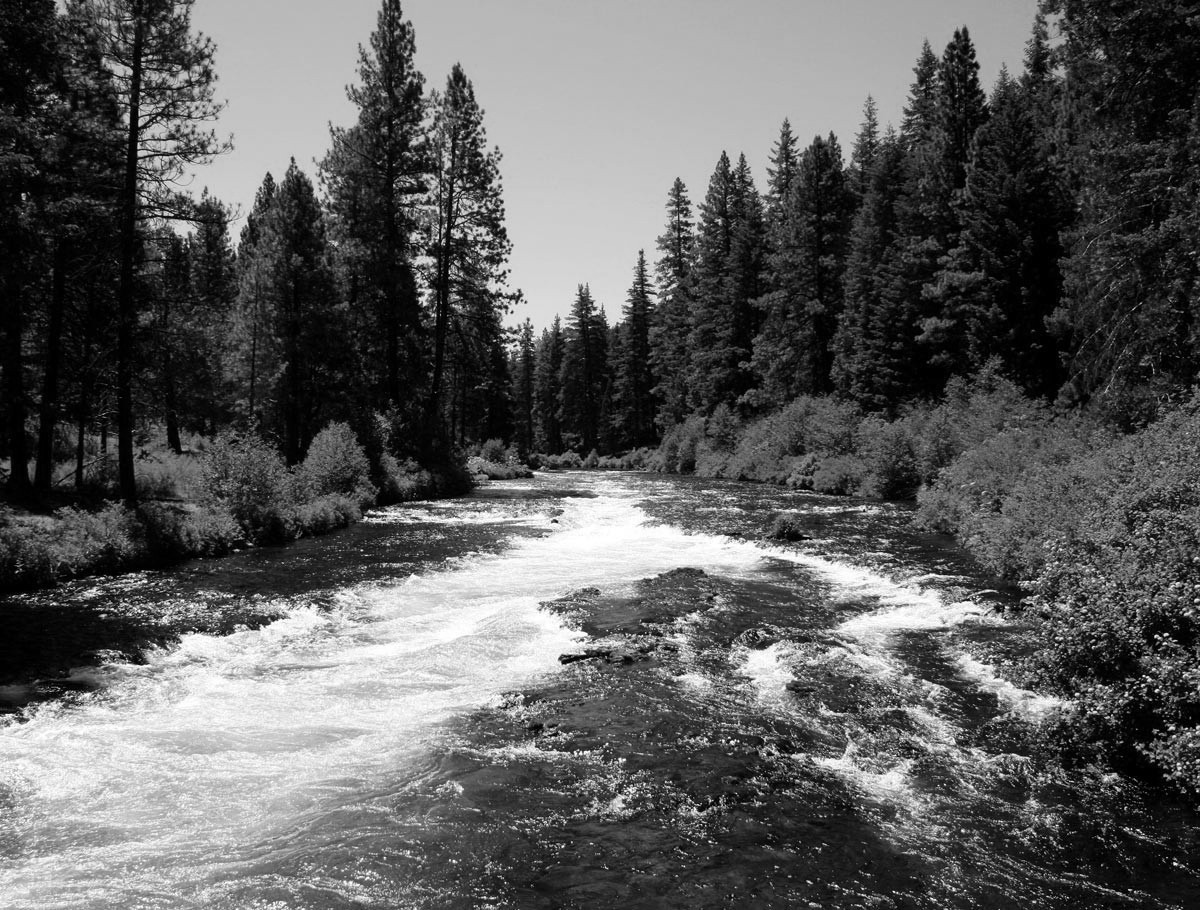

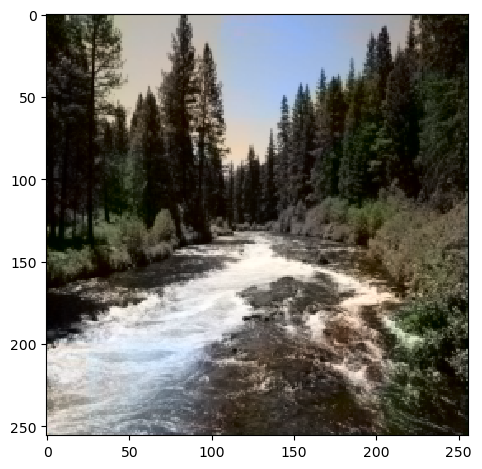

In [48]:
model = tf.keras.models.load_model('colorize_autoencoderv2.model', custom_objects=None, compile=True)

img_color = []

img = img_to_array(load_img('./grayimg/c.jpg'))
img = resize(img, (256, 256))
img_color.append(img)

img_color = np.array(img_color, dtype=float)
img_color = rgb2lab(1/255*img_color)[:,:,:,0]
img_color = img_color.reshape(img_color.shape+(1,))

output = model.predict(img_color)
output = output*128

result = np.zeros((256, 256, 3))
result[:, :, 0] = img_color[0][:,:,0]
result[:, :, 1:] = output[0]
imshow(lab2rgb(result))

Image(filename='./grayimg/c.jpg', width=260, height=260) 